In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aparpokhrel
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:14<00:00, 165MB/s]


In [4]:
from pathlib import Path

In [58]:
import os
import pandas as pd
import numpy as np
import tensorflow  as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
import cv2

In [44]:
data_dir = Path('/content/chest-xray-pneumonia/chest_xray/chest_xray')

test_dir = data_dir / 'test'

train_dir = data_dir / 'train'

val_dir = data_dir / 'val'


dataset_train = []
dataset_valid = []
dataset_test = []


labels = ['NORMAL', 'PNEUMONIA']

In [45]:
 
def load_train_dataset(): # creating function to load dataset_train
  for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_train.append([resize_img, class_num])
      except Exception as e:
        pass

def load_valid_dataset(): # function to load dataset_valid
  for label in labels:
    path = os.path.join(val_dir, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_valid.append([resize_img, class_num])
      except Exception as e:
        pass

def load_test_dataset(): # function to load dataset_test
  for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_test.append([resize_img, class_num])
      except Exception as e:
        pass

load_train_dataset()
load_valid_dataset()
load_test_dataset()

In [15]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_imgs = normal_cases_dir.glob('*.jpeg')
pneumonia_imgs = pneumonia_cases_dir.glob('*.jpeg')

train_dt = []

for img in normal_imgs:
  train_dt.append((img,0))

for img in pneumonia_imgs:
  train_dt.append((img,1))

train_dt = pd.DataFrame(train_dt, columns =['Image', 'Label'], index= None)

train_dt= train_dt.sample(frac=1.).reset_index(drop=True)

train_dt.head()


,Image,Label
0,/content/chest-xray-pneumonia/chest_xray/chest...,1
1,/content/chest-xray-pneumonia/chest_xray/chest...,0
2,/content/chest-xray-pneumonia/chest_xray/chest...,1
3,/content/chest-xray-pneumonia/chest_xray/chest...,1
4,/content/chest-xray-pneumonia/chest_xray/chest...,1


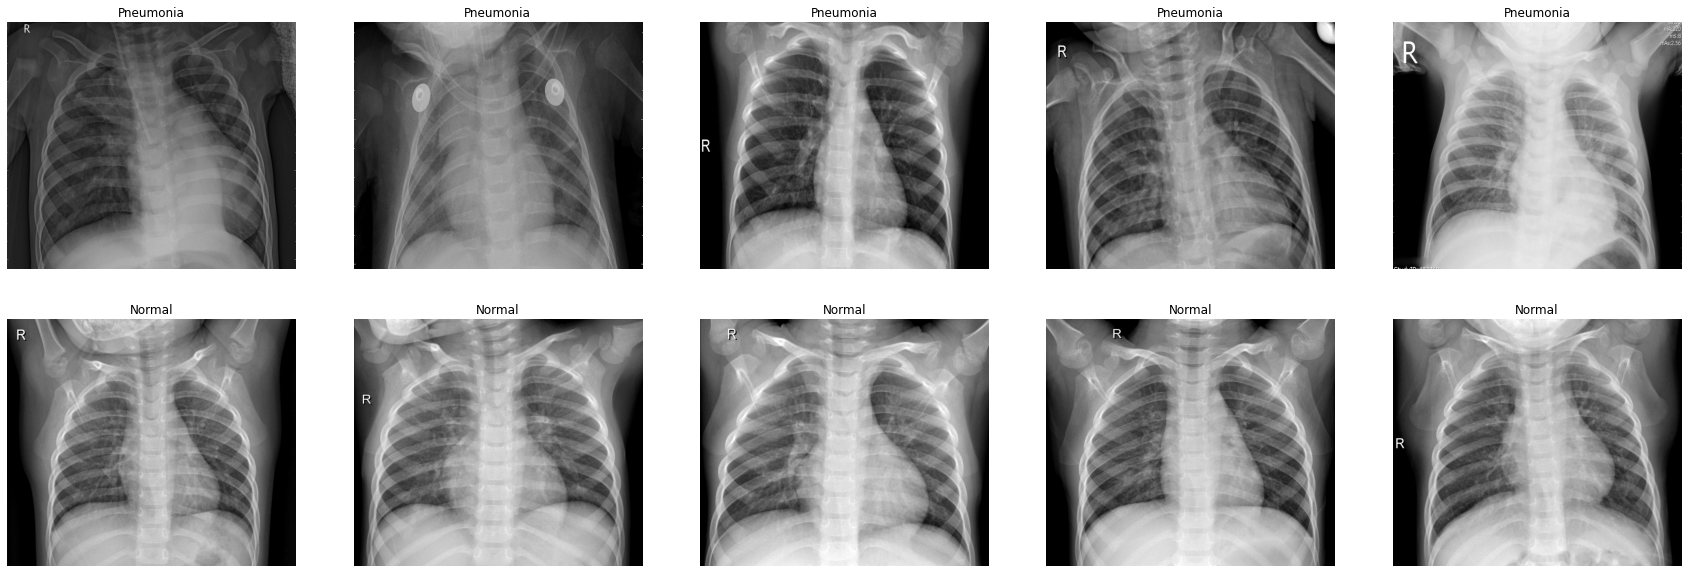

In [28]:
pneumonia_samples = (train_dt[train_dt['Label']==1]['Image'].iloc[:5]).tolist()
normal_samples = (train_dt[train_dt['Label']==0]['Image'].iloc[:5]).tolist()


samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [83]:
x_train, y_train = [], []
x_test, y_test = [], []
x_valid, y_valid = [], []


for fts, label in dataset_train:
  x_train.append(fts)
  y_train.append(label)

for features, label in dataset_valid:
  x_valid.append(fts)
  y_valid.append(label)

for features, label in dataset_test:
  x_test.append(fts)
  y_test.append(label)



1    3875
0    1341
Name: Label, dtype: int64


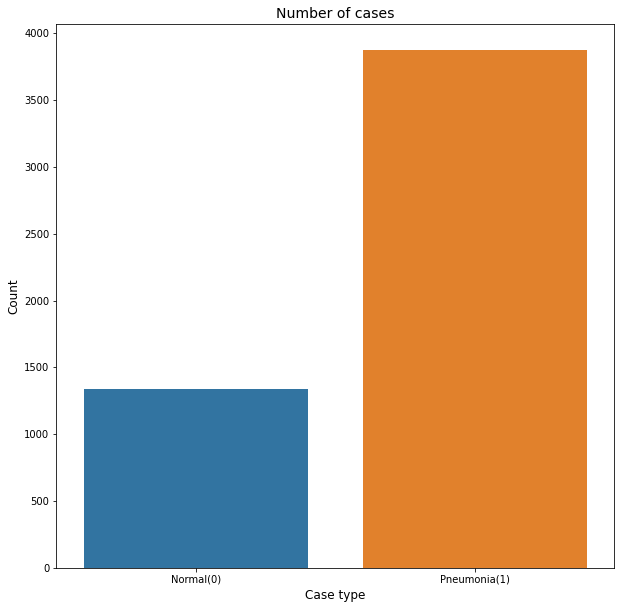

In [18]:
num_cases = train_dt['Label'].value_counts()
print(num_cases)

plt.figure(figsize=(10,10))
sns.barplot(x=num_cases.index, y= num_cases.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(num_cases.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [47]:
f_norm = lambda x: (np.array(x) / 255.0).astype('float32')

x_train = f_norm(x_train)
x_valid = f_norm(x_valid)
x_test = f_norm(x_test) 

# shape:
print('Shape x_train: {} \nShape x_valid: {} \nShape x_test: {}'.format(
    x_train.shape, x_valid.shape, x_test.shape))

Shape x_train: (5216, 150, 150) 
Shape x_valid: (16, 150, 150) 
Shape x_test: (624, 150, 150)


In [48]:
f_resize = lambda x: np.array(x).reshape(-1, 150, 150, 1)

x_train = f_resize(x_train)
x_valid = f_resize(x_valid)
x_test = f_resize(x_test)

# let's print the shape again to check the changes
print('Shape x_train: {} \nShape x_valid: {} \nShape x_test: {}'.format(
    x_train.shape, x_valid.shape, x_test.shape))

Shape x_train: (5216, 150, 150, 1) 
Shape x_valid: (16, 150, 150, 1) 
Shape x_test: (624, 150, 150, 1)


In [49]:
# function to convert to array
fc = lambda x: np.array(x)

x_train = fc(x_train)
y_train = fc(y_train)
x_valid = fc(x_valid)
y_valid = fc(y_valid)
x_test = fc(x_test)
y_test = fc(y_test)

In [51]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [52]:
datagen.fit(x_train)

In [55]:
model = Sequential()
model = keras.models.Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides=1 ,padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation='sigmoid'))

In [56]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)      

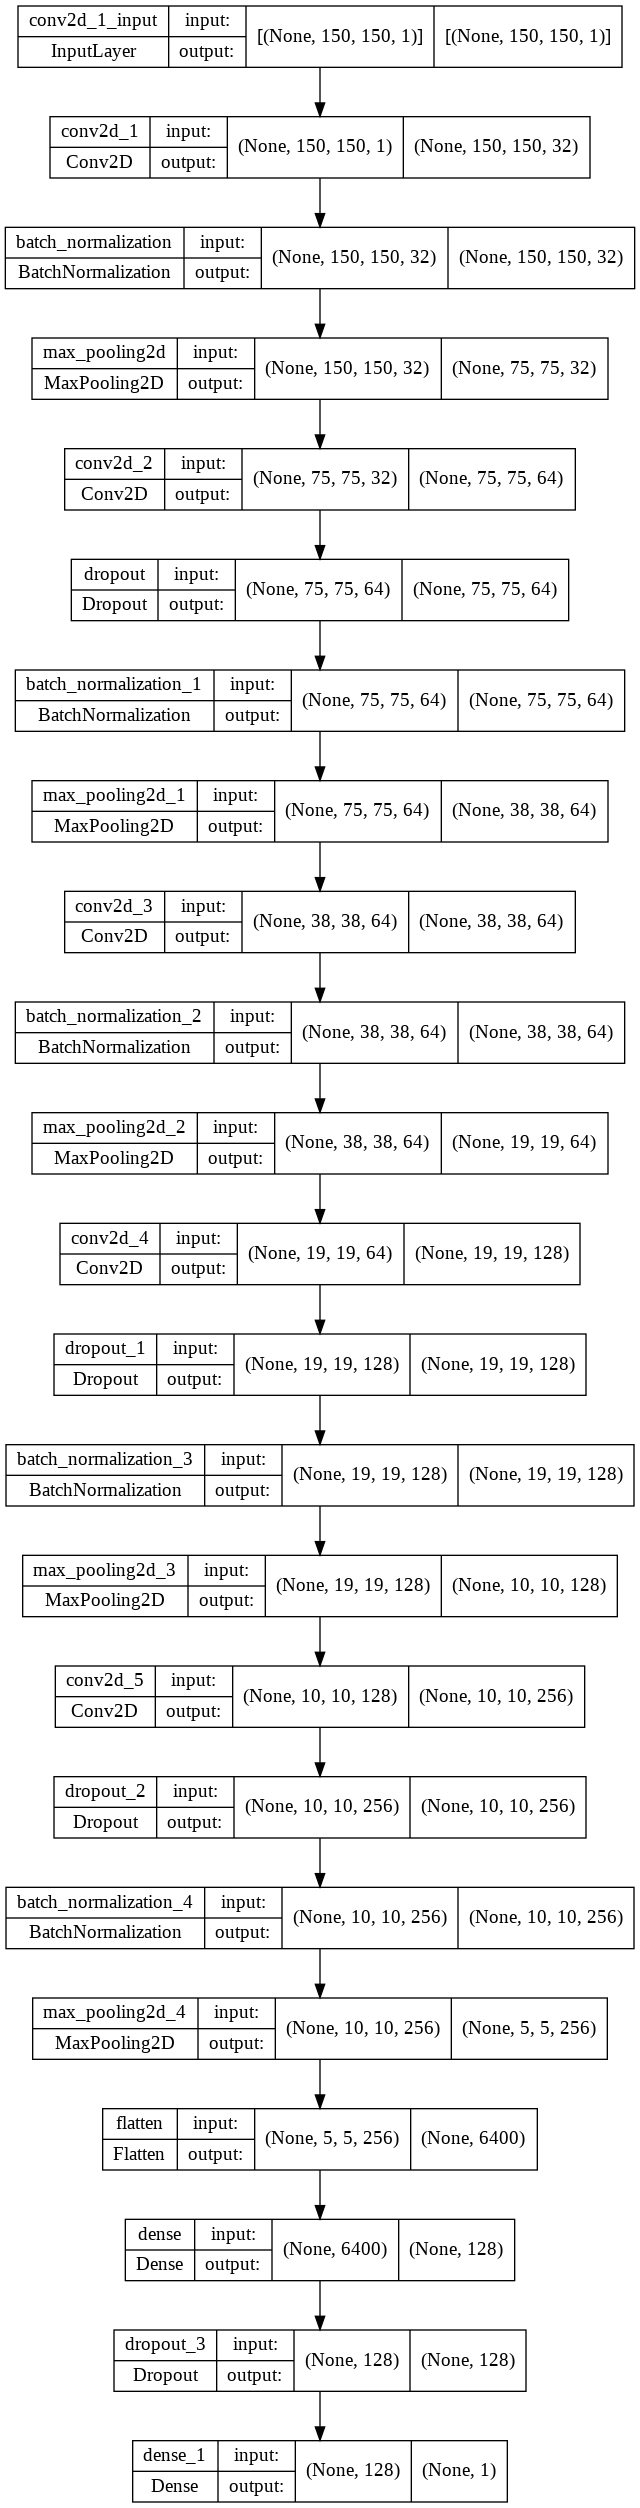

In [57]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=96)

In [59]:
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [60]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 30 , 
                    validation_data = datagen.flow(x_valid, y_valid) ,
                    callbacks = [lrr])

Epoch 1/30
163/163 [==============================] - 294s 2s/step - loss: 0.5424 - accuracy: 0.8422 - val_loss: 24.1863 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 293s 2s/step - loss: 0.2879 - accuracy: 0.8900 - val_loss: 72.2747 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9110
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 291s 2s/step - loss: 0.2420 - accuracy: 0.9110 - val_loss: 34.2858 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 289s 2s/step - loss: 0.1715 - accuracy: 0.9419 - val_loss: 17.2025 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9540
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==========================

In [88]:
img = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_485.jpeg'
img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
resize_img = cv2.resize(img_array, (150,150))

resize_img = np.array(resize_img) / 255.0
resize_img = f_resize(resize_img)



In [89]:
prediction  =model.predict(resize_img)
predicted_class = 'pneumonia' if prediction[0] > 0.5 else 'normal'
print(predicted_class)

pneumonia


In [90]:
model.save('model.h5')